# Building a GPT that can generate molecules from scratch

Molecules can be represented in multitude of ways. 
One of the most widely used representations is to use text, for example in the so-called SMILES notation.
In SMILES notation, a molecule is represented as a string of characters, where each character represents an atom or a bond.
For example, the SMILES notation for ethanol is `CCO`. The one for benzene is `c1ccccc1`. You see that hydrogen atoms are typically omitted in SMILES notation, and that lower case letters are used for aromatic atoms. 
There is a [full grammar for SMILES notation](http://opensmiles.org/opensmiles.html) and [various alternative representations](https://www.cell.com/patterns/pdf/S2666-3899(22)00206-9.pdf), but we will stick to this simple version for this notebook.

Important problems that our final solution will need to be able to solve are: 

- dealing with inputs of different lengths (e.g, different number of atoms in different molecules)
- incorporating information about the semantic meaning of the atoms in the molecule (to obtain meaningful molecules, the model, e.g., should probably "know" what kind of bonds carbon can form)
- dealing with the interaction between atoms in the molecule (not all arrangements of atoms are equally likely)

In [ ]:
import pandas as pd 
from rdkit import Chem
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import re 
from typing import List
import numpy as np 
from math import exp
import matplotlib.pyplot as plt
import torch

The functions below are helper functions that we will use throughout the notebook.

In [48]:
def get_num_parameters(model):
    """Return the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_num_parameters_per_layer(model):
    """Return the number of trainable parameters in the model per layer."""
    layers = {}
    for name, p in model.named_parameters():
        if p.requires_grad:
            layers[name] = p.numel()
    return layers


def set_device():
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            device = 'mps'
    elif torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = set_device()

## Dealing with SMILES 

Before we can do anything, we need to obtain data.  For doing so, we will need a dataset of SMILES strings. We will use the [ZINC dataset](https://zinc.docking.org/) which is a public database of commercially-available compounds. We will use the `250k` subset of the dataset which contains 250,000 compounds. 

In [6]:
!wget 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/zinc15_250K_2D.tar.gz'
!tar -xzf zinc15_250K_2D.tar.gz

/Users/kevinmaikjablonka/.zshenv:.:1: no such file or directory: /Users/kevinmaikjablonka/.cargo/env
--2024-05-02 12:20:55--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/zinc15_250K_2D.tar.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.120.49, 52.219.120.145, 52.219.193.50, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.120.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6941580 (6.6M) [application/x-gzip]
Saving to: ‘zinc15_250K_2D.tar.gz’

zinc15_250K_2D.tar. 100%[===================>]   6.62M  1.25MB/s    in 14s     

2024-05-02 12:21:11 (497 KB/s) - ‘zinc15_250K_2D.tar.gz’ saved [6941580/6941580]

/Users/kevinmaikjablonka/.zshenv:.:1: no such file or directory: /Users/kevinmaikjablonka/.cargo/env


After downloading and extracting the dataset, we can load it into memory and take a look at some molecules.

In [19]:
df = pd.read_csv('zinc15_250K_2D.csv')

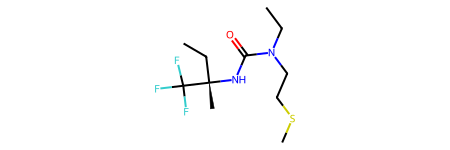

In [20]:
Chem.MolFromSmiles(df['smiles'][0])

Before we continue any further, we will also create train/valid and test sets.

In [21]:
train, valid, test = torch.utils.data.random_split(df['smiles'], [200000, 25000, 25000])

### Tokenization

For training a language model, we will need to split the SMILES into tokens. Tokens are the smallest units of text that the model will work with.
The model will learn to predict a molecule token by token.
There is not one correct way to do this, but one very common way is to split the SMILES into "chemical tokens". For this, [Philippe Schwaller wrote down a regular expression](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c8sc02339e).

Commonly used other tokenization methods are:

- [SentencePiece](https://github.com/google/sentencepiece)
- [Byte-Pair Encoding (BPE)](https://github.com/openai/tiktoken)

::: {.callout-note}
Some try to move completely away from tokenization and [directly](https://byte-gpt.github.io/) [model](https://www.youtube.com/watch?v=kcd0BTKJuXk) [bytes](https://arxiv.org/abs/2105.13626).
:::

In [22]:
def tokenize(smiles: str) -> List[str]:
    """
    Tokenize a SMILES

    Args:
        smiles (str): SMILES string
    
    Returns:
        List[str]: List of tokens
    """
    SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
    
    return re.findall(SMI_REGEX_PATTERN, smiles)

The molecule, CCO (ethanol), is tokenized as ['C', 'C', 'O'].

In [23]:
tokenize('CCO')

['C', 'C', 'O']

#### Converting tokens into IDs

For inputing tokens into a model, we will need to convert them into numbers.

To do so, we will set up a "vocabulary" which is a dictionary that maps tokens to integers.
The vocabulary also defines the tokens that are known to the model. 

#### Special tokens

Our model will be fed sequences of fixed length. Our SMILES, however, are of variable length. 
We will have to pad them to a fixed length. We will use a padding token for this purpose. 
That is, we will add a specific "[PAD]" token to the vocabulary which only serves the purpose of padding.

Often, we also add other tokens such as `[EOS]` (end of sequence) or `[BOS]` (beginning of sequence).

They are typically used as follows:

- `[BOS]` is added at the beginning of each sequence
- `[EOS]` is added at the end of each sequence
- `[PAD]` is added to the end of each sequence to pad it to a fixed length
- `[UNK]` is used to replace tokens that are not in the vocabulary


We can put all of this together in a `Tokenizer` class.

In [38]:
class Tokenizer:
    def __init__(self, tokens: List[str], eos: str = '[EOS]', bos: str = '[BOS]', pad: str = '[PAD]', unk: str = '[UNK]'):
        self.tokens = [pad, bos, eos, unk] + tokens
        self._token_to_index = {token: index for index, token in enumerate(self.tokens)}
        self.index_to_token = {index: token for index, token in enumerate(self.tokens)}

    def token_to_index(self, token: str) -> int:
        try:
            return self._token_to_index[token]
        except KeyError:
            return self._token_to_index['[UNK]']
        
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, item):
        return self.token_to_index[item]
    
    def __contains__(self, item):
        return item in self.tokens

    def encode(self, smiles: str, add_sos: bool=False, add_eos: bool=False) -> List[int]:
        """
        Encode a SMILES into a list of indices

        Args:
            smiles (str): SMILES string
            add_sos (bool): Add start of sentence token
            add_eos (bool): Add end of sentence token

        Returns:
            List[int]: List of indices
        """
        tokens = []
        if add_sos:
            tokens.append(self.token_to_index('[BOS]'))
        tokens += [self.token_to_index(token) for token in tokenize(smiles)]
        if add_eos:
            tokens.append(self.token_to_index('[EOS]'))
        return tokens
    
    def decode(self, indices: List[int], strip_special_tokens: bool = True) -> str: 
        """
        Decode a list of indices into a SMILES

        Args:
            indices (List[int]): List of indices
        
        Returns:
            str: SMILES string
        """
        decoded = ''.join([self.index_to_token[index] for index in indices])
        if strip_special_tokens:
            return decoded.replace('[PAD]', '').replace('[BOS]', '').replace('[EOS]', '')
        return decoded

To instantiate the tokenizer, we need to pass the list of tokens that we want to use. (This is sometimes called "training" the tokenizer, but in this case, we are just defining the tokens that we want to use.)
We will use the following tokens:

In [119]:
tokens = set()
lengths = []
for smiles in train.dataset.values:
    tokens_ = tokenize(smiles)
    tokens.update(tokens_)
    lengths.append(len(tokens_))


(array([3.0000e+00, 4.0000e+00, 7.0000e+00, 0.0000e+00, 2.3000e+01,
        5.6000e+01, 0.0000e+00, 7.8000e+01, 2.0100e+02, 0.0000e+00,
        3.8900e+02, 8.0200e+02, 1.4320e+03, 0.0000e+00, 2.5760e+03,
        3.9450e+03, 0.0000e+00, 5.8570e+03, 8.0820e+03, 0.0000e+00,
        1.0313e+04, 1.2675e+04, 1.4914e+04, 0.0000e+00, 1.7137e+04,
        1.8718e+04, 0.0000e+00, 2.0510e+04, 2.0796e+04, 0.0000e+00,
        2.1073e+04, 2.0330e+04, 1.8396e+04, 0.0000e+00, 1.6193e+04,
        1.2172e+04, 0.0000e+00, 9.8210e+03, 5.8470e+03, 0.0000e+00,
        3.9460e+03, 2.1220e+03, 9.6800e+02, 0.0000e+00, 4.1200e+02,
        1.4500e+02, 0.0000e+00, 4.6000e+01, 1.0000e+01, 1.0000e+00]),
 array([17. , 17.7, 18.4, 19.1, 19.8, 20.5, 21.2, 21.9, 22.6, 23.3, 24. ,
        24.7, 25.4, 26.1, 26.8, 27.5, 28.2, 28.9, 29.6, 30.3, 31. , 31.7,
        32.4, 33.1, 33.8, 34.5, 35.2, 35.9, 36.6, 37.3, 38. , 38.7, 39.4,
        40.1, 40.8, 41.5, 42.2, 42.9, 43.6, 44.3, 45. , 45.7, 46.4, 47.1,
        47.8, 48.5, 49

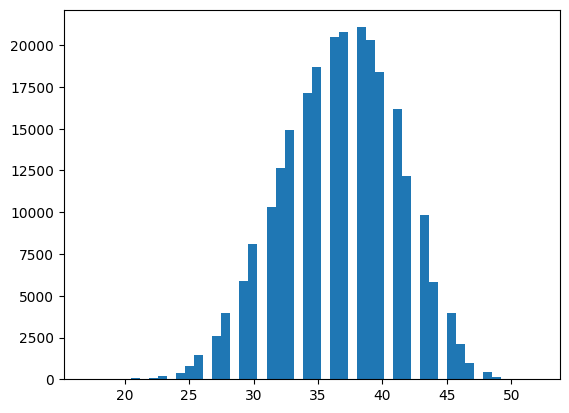

In [122]:
plt.hist(lengths, bins=50)

In [39]:
tokenizer = Tokenizer(list(tokens))

In [40]:
tokenizer.encode('CCO')

[45, 45, 38]

### Embeddings

Currently, we only encode the SMILES strings into a list of indices. 
There is no inherent meaning to the indices themselves, and we can improve modeling by representing each index as a vector. 
We call those vectors embeddings, but they are nothing more than a vector representation--like a feature vector--for each index.

Ideally, those vectors ensure that similar indices are close to each other in the embedding space.
There are many ways to create those embeddings. But for now it is only important to know this concept.

### Positional encoding

The embeddings we just created contain only information about their identity. 
However, they contain no information about their position in the sequence.

To add positional information, we can add a positional encoding to the embeddings. Again, there are many ways to do this.

A very simple way is called _absolute positional encoding_. For this we simply add the position index to the embedding vector.

For example 

```python
B, T, C = 2, 3, 4 # batch size, sequence length, embedding size
x = torch.rand(B, T, C)
pos = torch.arange(T).unsqueeze(0).repeat(B, 1)
```

### Language modeling dataset

A dataset class is a class that inherits from `torch.utils.data.Dataset`. It is used to load data into a model.

The most important methods of a dataset class are:

- `__len__`: This method returns the length of the dataset. It is used by the `DataLoader` to determine how many batches to load.
- `__getitem__`: This method returns a single sample from the dataset. It is used by the `DataLoader` to load a batch of samples.

In [266]:
class CausalLanguageModelingDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_length = max_length
        self.inputs = []
        self.targets = []

        for text in texts:
            input_ids = np.array(tokenizer.encode(text))
            if len(input_ids) > self.max_length:
                continue
            input_ids = self._pad_right(input_ids, self.max_length)
            # make next token the target create datasets with sliding windows
            for i in range(1, len(input_ids)):
                self.inputs.append(self._pad_left(input_ids[:i], self.max_length))
                self.targets.append([input_ids[i]])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids = self.inputs[idx]
        target_ids = self.targets[idx]

        return  torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)
    
    def _pad_left(self, sequence, max_len):
        pad_value = self.tokenizer.token_to_index('[PAD]')
        padded_sequence = np.full(max_len, pad_value)
        padded_sequence[-len(sequence):] = sequence
        return padded_sequence

    def _pad_right(self, sequence, max_len):
        pad_value = self.tokenizer.token_to_index('[PAD]')
        padded_sequence = np.full(max_len, pad_value)
        padded_sequence[:len(sequence)] = sequence
        return padded_sequence


You hopefully note something very interesting in this dataset: Based on one SMILES, we can create multiple training examples, because we can slide a window over the SMILES and predict the next token.  


**Note that our implementation is relatively naiive and is optimized to make this point clear. In practice, you should use dedicated methods, e.g., from the `transformers` library, to create language model datasets. I.e. instead of predicting only one token, we will directly predict the next tokens for all tokens in the input**

## A simple bigram model

The simplest language model is a bigram model. In a bigram model, we predict the next token based on the previous token.
A bigram model is the simplest form of `n-gram` model. In an `n-gram` model, we predict the next token based on the previous `n` tokens.

$N$-gram models are a simple but effective way to model language. The idea is to predict the next word in a sentence given the previous $n-1$ words. For example, in a 2-gram (bigram) model, we would predict the next word given only the previous word. In a 3-gram model, we would predict the next word given the previous two words. In general, we would predict the next word given the previous $n-1$ words.

Formally, we can write down the bigram model as follows:

$$
p(w_i|w_{i-1}) = \frac{C(w_{i-1}, w_i)}{C(w_{i-1})}
$$

where $w_i$ is the $i$-th word in the sentence, $C(w_{i-1}, w_i)$ is the number of times the bigram $w_{i-1}, w_i$ occurs in the training set, and $C(w_{i-1})$ is the number of times the word $w_{i-1}$ occurs in the training set.

Since the bigram model only considers the previous word/token, we only need a lookup table. 

Such lookup tables are implemented in PyTorch as `nn.Embedding`. Keep in mind that an embedding layer is nothing fancy. It works like inputting a one-hot encoded vector in a linear layer:


::: {.callout-note title="What are embedding layers?"}
Sebastian Raschka made a great figure about that.

<blockquote class="twitter-tweet" data-media-max-width="560"><p lang="en" dir="ltr">Embedding layers are often perceived as a fancy operation that we apply to encode the inputs (each word tokens) for large language models.<br>But embedding layers = fully-connected layers on one-hot encoded inputs. They just replace expensive matrix multiplications w index look-ups. <a href="https://t.co/0I3AFk4por">pic.twitter.com/0I3AFk4por</a></p>&mdash; Sebastian Raschka (@rasbt) <a href="https://twitter.com/rasbt/status/1611401567030083587?ref_src=twsrc%5Etfw">January 6, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

You can try it yourself using the following code (taken from Sebastian's tweet):

You can first use an embedding layer to encode the indices and then use a linear layer to do the same. You will see that the results are the same.

Here for example, we encode the indices `[2, 3, 1]` into a 5-dimensional vector using an embedding layer and a linear layer.
```python
torch.manual_seed(123);
idx = torch.tensor([2, 3, 1]) # 3 training examples
num_idx = max(idx)+1
out_dim = 5
embedding = torch.nn.Embedding(num_idx, out_dim)
embedding(idx)
```

The code for the linear layer is:
```python

torch.manual_seed(123);
idx = torch.tensor([2, 3, 1]) # 3 training examples
one_hot = torch.nn.functional.one_hot(idx, num_classes=num_idx)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight = torch.nn.Parameter(embedding.weight.T.detach()) # nn.Linear does xW^T, so we need to transpose the weight matrix
linear(one_hot.float())
```

:::

Using the `Embedding` layer, we can create a simple Bigram model. 

In [267]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size: int = 40):
        super().__init__()
        # "learnable dictionary" that maps one token to another token
        self.mapping_layer = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # the forward pass only consists of a lookup in the mapping layer
        return self.mapping_layer(x)
    
    def loss(self, x, y): 
        # x has shape (batch_size, sequence_length)
        predictions = self.forward(x)
        B, T, C = predictions.shape
        
        # predictions has shape (batch_size, sequence_length, vocab_size)
        predictions = predictions.view(B*T, C)
        
        # y has the shape (batch_size, sequence_length)
        y = y.view(B*T)

        # we use cross entropy loss to train the model
        return F.cross_entropy(predictions, y)


In [268]:
bigram = BigramModel(10)

Given a token ID, the model predict how likely each token of the vocabulary is to be the next. Right now, the model is not trained, so it will predict the next token randomly.

In [269]:
F.softmax(bigram(torch.tensor([1])))

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_51170/730608109.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(bigram(torch.tensor([1])))


tensor([[0.0465, 0.0137, 0.0966, 0.0857, 0.3933, 0.0212, 0.0415, 0.0283, 0.0550,
         0.2181]], grad_fn=<SoftmaxBackward0>)

For generating a sequence, we can implement a `generate` method that iteratively predicts the next token and appends it to the sequence. We can then use this method to generate a sequence of a given length.

In [288]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # read of the logits of the next token from table
        self.mapping_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x):
        # x is a tensor of shape (B, T)
        return self.mapping_table(x) # returns tensor of shape (batch_size, time_steps, vocab_size)
    
    def loss(self, x, y):
        # x is a tensor of shape (B, T)
        logits = self.forward(x) # (B, T, C)
        B, T, C = logits.shape

        # Note that that the implementation below is because of how we - for educational purposes - have defined the dataset
        # A better way is to have inputs and outputs of the same length (and to not manually code the sliding window
        # but to instead use a causal mask)

        # in our case, y only contains the next token
        # so we only care about the last token in Bigram
        logits = logits[:, -1, :]
        logits = logits.view(B, C)
        y = y.view(B)
        
        return F.cross_entropy(logits, y)
    
    def generate(self, x, max_new_tokens=100):
        # x is a tensor of shape (B, T)
        # we generate max_new_tokens new tokens
        new_tokens = []
        for _t in range(max_new_tokens):
            logits = self.forward(x) # (B, T, C)

            logits = logits[:, -1, :] # we only care about the last token in Bigram, hence we bow have shape (B, C)
            probs = F.softmax(logits, dim=-1) # we generate probabilities for the next token

            # torch.multinomial(probs, num_samples=1) returns a tensor of shape (B, 1) 
            # where each element is the index of the sampled token
            next_token = torch.multinomial(probs, num_samples=1)
            new_tokens.append(next_token)
            x = torch.cat([x, next_token], dim=1)
        return x
        
    

To evaluate the model performance, we will use the helper function below.

As performance metric we will use perplexity. Perplexity is a metric that measures how well a probability model predicts a sample. It is defined as $2^H$, where $H$ is the cross entropy loss. The lower the perplexity, the better the model.


To better understand it, let's recall a few things: 

LLMs are trained to predict the probability of a word given the previous words. For instance, in the sentence "She went to the...", the model predicts the probability of what the next word could be (e.g., store, park, etc.).

_Cross entropy_ is a measure of the difference between two probability distributions - in this case, the distribution predicted by the model and the actual distribution of words in the language. A lower cross-entropy means the model's predictions are closer to the actual distribution. We can calculate it as follows:

$$H(p,q) = - \sum_{x} p(x) \log q(x)$$

where $p$ is the actual distribution and $q$ is the predicted distribution. 

_Perplexity_ can be thought of as the "effective number of choices" the model feels it has when making a prediction. A lower perplexity indicates that the model is more confident (or less "perplexed") about its predictions.

For example, if a model has a perplexity of 10 on a dataset, it means that, on average, each time it tries to predict the next word, it's as uncertain as if it were choosing uniformly and randomly among 10 options. If the perplexity is 100, it's as uncertain as if it were choosing among 100 options, and so on.

You can find further information about such metrics [here](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/).

In [289]:
@torch.no_grad()
def estimate_perplexity(model, data_loader):
    # set the model to evaluation mode, i.e., 
    model.eval()
    total_loss = 0
    total_count = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = model.loss(x, y)
        total_loss += loss.item()
        total_count += 1
    return exp(total_loss / total_count)

### Training the model

To train the model, we will use a simple training loop and the Adam optimizer.

The role of the `Adam` optimizer is to update the parameters of the model using a technique called [mini-batch stochastic gradient descent](http://d2l.ai/chapter_optimization/minibatch-sgd.html).
The idea is that we update the weights in the direction of the gradient of the loss function, which we estimate on a small batch of data. The learning rate controls how big the steps are that we take in the direction of the gradient.

Setting learning rate is not trivial, you can find more background [here](https://www.jeremyjordan.me/nn-learning-rate/).

It is import to remember to use the `zero_grad` function to clear the gradients before computing the gradients for the current batch. Also, remember to call `loss.backward()` to compute the gradients for the current batch.

For now, we will use a very simple approach (to reuse our old dataloader) and just predict the second token given the first one.

In [290]:
model = BigramModel(len(tokenizer))

In [291]:
train_loader = torch.utils.data.DataLoader(CausalLanguageModelingDataset(train, tokenizer, max_length=40), batch_size=2048, shuffle=True)
valid_loader = torch.utils.data.DataLoader(CausalLanguageModelingDataset(valid, tokenizer, max_length=40), batch_size=2048)
test_loader = torch.utils.data.DataLoader(CausalLanguageModelingDataset(test, tokenizer, max_length=40), batch_size=2048)

In [292]:
def train_model(model, train_loader, val_loader, epochs, lr, eval_every=100):
    # set up the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    # start training
    # set the model to train mode 
    model.train()
    for epoch in range(epochs):


        # iterate over the training data
        for i, (x,y) in enumerate(train_loader):
            # move the data to the device
            x = x.to(device)
            y = y.to(device)
            loss = model.loss(x,y)
            # clear the gradients
            optimizer.zero_grad()
            # compute the gradients
            loss.backward()
            # update the parameters
            optimizer.step()

            # print the loss every eval_every iterations
            if i % eval_every == 0:
                print(f"Epoch {epoch}, iter {i}, train loss {loss.item():.3f}, val perplexity {estimate_perplexity(model, val_loader):.5f}")

In [293]:
train_model(model, train_loader, valid_loader, epochs=10, lr=1e-3, eval_every=100)

Epoch 0, iter 0, train loss 4.247, val perplexity 68.89613
Epoch 0, iter 100, train loss 4.084, val perplexity 58.78415
Epoch 0, iter 200, train loss 3.887, val perplexity 50.44378
Epoch 0, iter 300, train loss 3.770, val perplexity 43.52746
Epoch 0, iter 400, train loss 3.647, val perplexity 37.78621
Epoch 0, iter 500, train loss 3.483, val perplexity 32.99921
Epoch 0, iter 600, train loss 3.302, val perplexity 28.98877
Epoch 0, iter 700, train loss 3.246, val perplexity 25.62722
Epoch 0, iter 800, train loss 3.124, val perplexity 22.79053
Epoch 0, iter 900, train loss 3.014, val perplexity 20.38747
Epoch 0, iter 1000, train loss 2.925, val perplexity 18.34650
Epoch 0, iter 1100, train loss 2.821, val perplexity 16.60504
Epoch 0, iter 1200, train loss 2.695, val perplexity 15.11995
Epoch 0, iter 1300, train loss 2.618, val perplexity 13.84288
Epoch 0, iter 1400, train loss 2.565, val perplexity 12.74738
Epoch 0, iter 1500, train loss 2.524, val perplexity 11.80145
Epoch 0, iter 1600, 

We can now test the model by generating new SMILES strings. We will start with a random token and generate 100 new tokens.

In [368]:
a = torch.tensor([[4]])
a = a.to(device)
generation = model.generate(a, max_new_tokens=30).cpu().numpy()
smiles = tokenizer.decode(generation[0])

In [369]:
smiles

'[C@@](O)C'

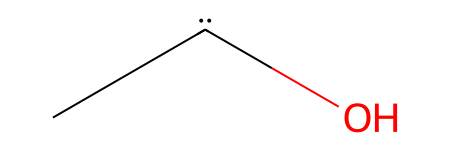

In [370]:
Chem.MolFromSmiles(smiles)

This does not look too bad, but we can do better (if you would run the code multiple times, you would see that the results are not always a valid SMILES).

## Making tokens talk using attention

In our bigram models we made predictions based on the previous word.
This is clearly not enough to make good predictions.
We can improve our model by taking into more past tokens into account.

One naïve way to incorporate more context into our model might be to simply "pool" (features of) the preceding tokens.
This kind of pooling is similar to what we do in GNNs, e.g., to combine node embeddings. 

A very simple pooling operation is the average of the embeddings of the preceding tokens. Later, when we will implement self-attention, we will not use a simple average, but a special weighted average. 

In [371]:
B, T, C = 2, 5, 3 # batch size, time (sequence length), channels (features)

# create random data of shape (B, T, C)
x = torch.randn(B,T,C)

x_bag_of_words = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        x_prev = x[b,:t+1] # shape (t, C)
        
        x_bag_of_words[b, t] = torch.mean(x_prev, dim=0) # shape (C,)

### Interlude: Causal masking

This nested for loop for averaging is slow. However, we can implement this in an efficient way if we observe a few things: 

- If we want to predict next tokens, we do not want to let the future tokens influence the prediction. 
Therefore, we can use a so-called causal mask to mask out the future tokens.

- A matrix multiplication can be thought of as a weighted sum of the rows of the matrix, where the weights are given by the columns of the matrix. This is easy to see if we think of the following extremes: 

  - We can compute the sum of the rows of a matrix by multiplying the matrix with a lower-triangular matrix filled with ones.
   - We can compute the mean of the rows of a matrix by multiplying the matrix with a lower-triangular matrix filled with ones and dividing by the number of ones in the lower-triangular matrix.
  

In `torch` we can use `tril` to create a lower-triangular matrix.

In [372]:
lower_triangular_mask = torch.tril(torch.ones((T,T)))

weight = torch.ones((T,T))
weight = torch.masked_fill(weight, lower_triangular_mask==0, float('-inf'))

weight = torch.softmax(weight, dim=1)

In [373]:
weight  

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000]])

We used the softmax function to normalize the weights in the rows. 

In [374]:
weight @ x

tensor([[[ 2.7713,  0.4576,  2.1195],
         [ 1.8329,  0.5148,  0.9036],
         [ 0.9509,  0.0041,  0.9987],
         [ 0.3513, -0.1176,  0.5793],
         [ 0.1679, -0.1204,  0.5011]],

        [[-0.3739, -0.3857, -0.7389],
         [-0.5810, -0.5098, -1.7110],
         [-0.3690, -0.4240, -1.1107],
         [-0.0953, -0.3274, -0.5838],
         [ 0.1815, -0.3243, -0.4050]]])

### Attention as special weighted average

In the simple average we used above, all past tokens were treated equally.
However, it might be useful to _pay more attention_  to certain tokens than to others. That is, we want to gather information from the past -- but do this in a data-dependent way.
The attention mechanism allows us to do this.

The attention mechanism does this by having a query vector $q$ and a key vector $k$ for each token. We then define "similarity" or "relevance" between two tokens $i$ and $j$ as the dot product between their query and key vectors, which we derive from the embeddings of the tokens by multiplying them with the learnable weight matrices $W_q$ and $W_k$.

$$
\text{sim}(i, j) = a(i, h) = q_ik_j^T = \text{emb}_i W_q W_k^T \text{emb}_j^T
$$

Note that this gives us now a way to refine the `weight_matrix` we used above. Instead of weighting all tokens equally, we can now learn a weight matrix that tells us how much attention to pay to each token.

To start the implementation, we will first derive query and key vectors from the embeddings. We will then compute the similarity matrix and apply the softmax function to normalize the weights.

In [375]:
B, T, C = 2, 5, 3 # batch size, time (sequence length), channels (features)
x = torch.randn(B,T,C)

head_size = 16 # hyperparameter

# with bias = False, it only perform matrix multiplication
key_layer = nn.Linear(C, head_size, bias=False)  
query_layer = nn.Linear(C, head_size, bias=False)

The attention matrix defined above is now a simple matrix multiplication between the query and key vectors. The attention matrix is then normalized using a softmax function.

In [376]:
query = query_layer(x) # shape (B, T, head_size)
key = key_layer(x) # shape (B, T, head_size)

In [377]:
attention = query @ key.transpose(1,2) # shape (B, T, T)

Note that the shape of the attention matrix is (B, T, T). The attention matrix is a matrix where each row corresponds to a query and each column corresponds to a key. The value at position (i, j) in the attention matrix is the attention score between the i-th query and the j-th key.

In [378]:
attention

tensor([[[-0.1377,  0.3945, -0.1910, -0.3166,  0.5705],
         [ 0.2263, -1.1153,  0.0163,  1.0653, -0.9115],
         [-0.3157,  0.5693, -0.7330, -0.4713,  1.6627],
         [-0.1497,  0.9112, -0.0370, -1.1351,  1.1552],
         [ 0.6523, -1.6878,  1.3558,  1.8505, -4.0957]],

        [[-0.4646,  0.6153, -0.3081,  1.0515,  0.5917],
         [ 0.3343, -1.2245, -0.7600, -1.6172, -1.2108],
         [-0.6809, -0.0852, -1.6940,  0.4584, -0.1262],
         [ 0.7665, -1.8694, -0.5606, -2.6797, -1.8310],
         [ 0.2937, -1.1780, -0.7986, -1.5304, -1.1683]]],
       grad_fn=<UnsafeViewBackward0>)

But to avoid the future tokens to influence the prediction, we will use a causal mask.
We do this the same way as we did above, by using `torch.tril`.

In [379]:
lower_triangular_mask = torch.tril(torch.ones((T,T)))

attention = torch.masked_fill(attention, lower_triangular_mask==0, float('-inf'))   

attention = torch.softmax(attention, dim=2) # shape (B, T, T), softmax along the last dimension

out = attention @ x # shape (B, T, T) @ (B, T, C) = (B, T, C)

In the attention mechanism popularized in the ["attention is all you need" paper](https://arxiv.org/abs/1706.03762) we add even more expressive power by transforming `x` before we multiply it with the attention matrix. We call this transformed `x` the value vector (or matrix). The full implementation of the attention mechanism is then:

In [380]:
B, T, C = 2, 5, 3 # batch size, time (sequence length), channels (features)
x = torch.randn(B,T,C)

head_size = 16 # hyperparameter

# what do I contain
# with bias = False, it only perform matrix multiplication
key = nn.Linear(C, head_size, bias=False)

# what am I looking for
query = nn.Linear(C, head_size, bias=False)

# what I will tell you
value = nn.Linear(C, head_size, bias=False) # Output: (B, T, head_size)
# self-attention because k, q, v come all from the same input
k = key(x) # shape (B, T, head_size)
q = query(x) # shape (B, T, head_size)
v = value(x) # shape (B, T, head_size)

# now, we want to compute the attention
# we need to compute the dot product between k and q
weight_matrix = q @ k.transpose(-2, -1) # shape (B, T, head_size) @ (B, head_size, T) = (B, T, T)

# now we add the masking
# we want to mask out the future
# this is what is known as "decoder" block 
lower_triangular = torch.tril(torch.ones((T,T)))
weight_matrix = weight_matrix.masked_fill(lower_triangular==0, float('-inf'))

# use softmax to normalize
weight_matrix = torch.softmax(weight_matrix, dim=-1)/np.sqrt(head_size) # shape (B, T, T)

out = weight_matrix @ v # shape (B, T, T) @ (B, T, head_size) = (B, T, head_size)

#### Interlude: Why do we divide by sqrt(head_size) in the self-attention mechanism?

We used one more trick to make the training more stable. We scaled the weight_matrix by the square root of the head_size. [This is because the variance of the dot product is proportional to the dimensionality of the vectors.](https://ai.stackexchange.com/questions/21237/why-does-this-multiplication-of-q-and-k-have-a-variance-of-d-k-in-scaled). Not scaling the weight matrix can lead to numerical instability.

To see this, let's run a quick experiment

In [381]:
variances = []
dimensions = [1, 10, 100, 1000, 10000, 100000]

for d in dimensions:

    k = torch.randn(B, T, d)
    q = torch.randn(B, T, d)

    # compute the batched matrix product between k and q
    weight_matrix = torch.bmm(q, k.transpose(-2, -1))   # shape (B, T, head_size) @ (B, head_size, T) = (B, T, T)
    variances.append(weight_matrix.var())

Text(0, 0.5, 'Variance')

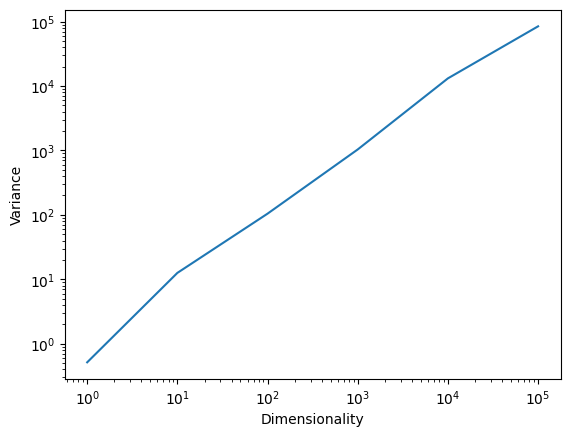

In [382]:
plt.plot(dimensions, variances)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dimensionality')
plt.ylabel('Variance')

This has an important impact when we apply `softmax`.
Positive and negative "outliers" will be "sequeezed" to 1 and 0. You can test this by creating a 1D tensor (`a`) and applying softmax on it. 
Then multiply the values in the tensor  (`a`) and again apply softmax. 

In [383]:
print(F.softmax(torch.tensor([1.,2.,3.])),F.softmax(torch.tensor([1.,2.,3.])*100) )

tensor([0.0900, 0.2447, 0.6652]) tensor([0.0000e+00, 3.7835e-44, 1.0000e+00])


/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_51170/1895642280.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(torch.tensor([1.,2.,3.])),F.softmax(torch.tensor([1.,2.,3.])*100) )


#### The attention mechanism

Written as a formula, the attention mechanism is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where $Q$ is the query matrix, $K$ is the key matrix, and $V$ is the value matrix.

### Refactoring into a module

In [384]:
class Head(nn.Module):

    def __init__(self, n_embed, block_size, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        
        self.register_buffer('lower_triangular', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x): 
        B, T, C  = x.shape
        key = self.key(x)
        query = self.query(x) # B, T, head
        value = self.value(x)   # B, T, head

        weight_matrix = query @ key.transpose(-2, -1) * C ** (-0.5) # shape (B, T, head_size) @ (B, head_size, T) = (B, T, T)
        weight_matrix = weight_matrix.masked_fill(self.lower_triangular[:T, :T].logical_not(), float('-inf'))
        weight_matrix = F.softmax(weight_matrix, dim=-1)

        out = weight_matrix @ value # shape (B, T, T) @ (B, T, head_size) = (B, T, head_size)
        return out

### Revamped Bigram Model

Now, we can use it to "refine" our bigram model. 
We will additionally also perform two more changes:

- we will add positional embeddings: We will add the positional embeddings to the input embeddings. This will allow the model to take into account the position of the tokens in the sequence.
- we will add one more indirection: One simple way of improving the expressiveness is to add one linear layer. While in the bigram model we only had one embedding layer (that mapped inputs of size `vocab_size` to `vocab_size`), we can now change the embedding layer to map inputs of size `vocab_size` to `embedding_size`. We can then add a linear layer that maps inputs of size `embedding_size` to `vocab_size`. This way, we can learn a more complex mapping from the embeddings to the next token.

In [385]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, sequence_length=100, head_size=4):
        super().__init__()

        # map the input ids to embeddings
        self.token_embedding =  nn.Embedding(vocab_size, embedding_dim)

        # add positional embeddings (each position has its own learnable embedding vector)
        self.positional_embedding = nn.Embedding(sequence_length, embedding_dim)

        # the self-attention layer
        self.attention = Head(embedding_dim, sequence_length, head_size)

        # the linear layer that maps the output of the self-attention layer to the vocabulary size
        self.lm_head = nn.Linear(head_size, vocab_size)

        # store the sequence length
        self.sequence_length = sequence_length

    def forward(self, x):
        B, T = x.shape
        x = self.token_embedding(x) # B, T, C 
        x += self.positional_embedding(torch.arange(T, device=device)) # B, T, C
        x = self.attention(x) # B, T, head_size
        x = self.lm_head(x) # B, T, vocab_size
        # The prediction is for each token a probability distribution over the vocabulary
        # this indicates how likely each token is the next token
        return x

        
    def loss(self, x, y):
        # x is a tensor of shape (B, T)
        logits = self.forward(x) # (B, T, C)
        B, T, C = logits.shape

        # Note that that the implementation below is because of how we - for educational purposes - have defined the dataset
        # A better way is to have inputs and outputs of the same length (and to not manually code the sliding window
        # but to instead use a causal mask)
        logits = logits[:, -1, :] # we only care about the last token 
        logits = logits.view(B, C)
        y = y.view(B)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def generate(self, x, max_new_tokens=100):
        # x is a tensor of shape (B, T)
        # we generate max_new_tokens new tokens
        for _t in range(max_new_tokens):
            logits = self.forward(x)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            x = torch.cat([x, next_token], dim=1)
        return x
        
    

In [386]:
model = SelfAttentionModel(len(tokenizer.tokens), embedding_dim=128, sequence_length=40, head_size=16)

train_model(model, train_loader, valid_loader, epochs=10, lr=1e-3)

Epoch 0, iter 0, train loss 3.889, val perplexity 46.51448
Epoch 0, iter 100, train loss 1.883, val perplexity 6.66113
Epoch 0, iter 200, train loss 1.638, val perplexity 5.01923
Epoch 0, iter 300, train loss 1.536, val perplexity 4.70023
Epoch 0, iter 400, train loss 1.548, val perplexity 4.58597
Epoch 0, iter 500, train loss 1.504, val perplexity 4.38599
Epoch 0, iter 600, train loss 1.441, val perplexity 4.25886
Epoch 0, iter 700, train loss 1.469, val perplexity 4.18827
Epoch 0, iter 800, train loss 1.392, val perplexity 4.15055
Epoch 0, iter 900, train loss 1.401, val perplexity 4.07537
Epoch 0, iter 1000, train loss 1.405, val perplexity 3.99194
Epoch 0, iter 1100, train loss 1.363, val perplexity 3.90569
Epoch 0, iter 1200, train loss 1.358, val perplexity 3.86271
Epoch 0, iter 1300, train loss 1.274, val perplexity 3.82789
Epoch 0, iter 1400, train loss 1.339, val perplexity 3.80141
Epoch 0, iter 1500, train loss 1.336, val perplexity 3.77024
Epoch 0, iter 1600, train loss 1.32

In [405]:
a = torch.tensor([[tokenizer.token_to_index('C')]])
a = a.to(device)
generation = model.generate(a, max_new_tokens=30).cpu().numpy()
tokenizer.decode(generation[0])

'C33O4N4S4=ON[C@@H](S)NN'

This is not a good model for generating molecules yet ... (even though our validation loss is lower.

## Interlude: Additional perspectives on attention

### Attention as GNN

- In the attention mechanism we learn how different tokens "communicate" with each other. If we think of tokens as nodes, attention corresponds to learning the edge weights of a fully connected graph.

- The tokens per default have no notion of their position in the sequence. It is basically the communication between sets of vectors.

In attentional GNNs, we write for the embeddings: 

$$
\mathbf{h}_i=\phi\left(\mathbf{x}_i, \bigoplus_{j \in \mathcal{V}} a\left(\mathbf{x}_i, \mathbf{x}_j\right) \psi\left(\mathbf{x}_j\right)\right)
$$ 

where $\bigoplus$ is a permutation invariant function, e.g., sum or mean over the neighborhood $\mathcal{V}$. [Does this equation look familiar?](https://petar-v.com/talks/GNN-EEML.pdf)


You can find more information [here](https://thegradient.pub/transformers-are-graph-neural-networks/) and [here](https://arxiv.org/pdf/2301.08210.pdf).

The main difference is that in the transformer we model a fully connected graph, whereas in GNNs we model a sparse graph (which is an inductive bias). 

### Attention as Kernel smoothing

- Given that we have been introducing the attention mechanism as a way to compute a weighted average of values, the analogy to a kernel is quite natural.

To understand this a bit better, let us introduce [kernel smoothing](https://en.wikipedia.org/wiki/Kernel_regression). Again, it is nothing else then a weighted average. In this weighted average, the weights are determined by a kernel function.

$$
\sum_{i=1}^n y_i \frac{K\left(x_i, x_o\right)}{\sum_{j=1}^n K\left(x_j, x_o\right)},
$$

where $(x_1, y_1), \dots, (x_n, y_n)$ are the training points and $x_o$ is the point at which we want to make a prediction.

A common kernel function is the Gaussian kernel:

$$
K(x, x_o) = \exp\left(xx_o\right)
$$

where $\sigma$ is a hyperparameter.

We are also free to add weights 

$$
K(x, x_o) = \exp\left(\mathbf{w}_1 x  \mathbf{w}_2 x_o\right)
$$

where $w$ are square weight matrices. For stability, we might divide by the dimensionality of $x$.

$$
K(x, x_o) = \exp\left(\frac{\mathbf{w}_1 x  \mathbf{w}_2 x_o}{\sqrt{d}}\right)
$$

where $d$ is the dimensionality of $x$.

Compare this to the attention equation:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where $d_k$ is the dimension of $K$ and $Q$.

You can find more information on this perspective [here](http://bactra.org/notebooks/nn-attention-and-transformers.html).

## Adding more expressive power with more heads and fully connected layers

A very simple way to improve the attention mechanism is to use multiple attention heads.
That is we apply the attention mechanism multiple times and then concatenate the results.

The intuition behind this is that different attention heads can learn different attention patterns.

In [406]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, n_embed, block_size, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, block_size, head_size) for _ in range(num_heads)])

    def forward(self, x):
        # x is a tensor of shape (B, T, C)
        # we want to compute the attention for each head
        # and then concatenate the results
        # we will have a tensor of shape (B, T, num_heads * head_size)
        # in practice, we might not concatenate but add another dimension
        # to the tensors
        return torch.cat([head(x) for head in self.heads], dim=-1)

Once we let the tokens talk to each other we currently only used one linear layer to map to the outputs. 
We can expect better performance if we use multiple layers.

One typically uses wide linear layers that can more readily be parallelized than deep linear layers.

In [407]:
class FeedForwardLayer(nn.Module):
    def __init__(self, n_embed, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_embed)
        )
        
    def forward(self, x):
        return self.net(x)

If we put it together, it looks like this:

In [408]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, sequence_length=100, head_size=12, num_heads=4):
        super().__init__()
        # read of the logits of the next token from table
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_embedding = nn.Embedding(sequence_length, embedding_dim)
        self.lm_head = nn.Linear(head_size, vocab_size)
        self.sequence_length = sequence_length
        self.attention = MultiHeadAttention(num_heads, embedding_dim, sequence_length, head_size)
        self.feed_forward = FeedForwardLayer(embedding_dim, 4*embedding_dim)

    def forward(self, x):
        B, T = x.shape
        x = self.token_embedding(x)
        x += self.positional_embedding(torch.arange(T, device=device))
        x = self.attention(x)
        x = self.lm_head(x)
        return x
    
    def loss(self, x, y):
        # x is a tensor of shape (B, T)
        logits = self.forward(x) # (B, T, C)
        B, T, C = logits.shape
        # Note that that the implementation below is because of how we - for educational purposes - have defined the dataset
        # A better way is to have inputs and outputs of the same length (and to not manually code the sliding window   
        logits = logits[:, -1, :]
        logits = logits.view(B, C)
        y = y.view(B)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def generate(self, x, max_new_tokens=100):
        # x is a tensor of shape (B, T)
        # we generate max_new_tokens new tokens
        new_tokens = []
        for _t in range(max_new_tokens):
            x_ = x[:, -self.sequence_length:]
            logits = self.forward(x_) # (B, T, C)
            logits = logits[:, -1, :] # we only care about the last token in Bigram, hence we bow have shape (B, C)
            probs = F.softmax(logits, dim=-1) # we generate probabilities for the next token

            # torch.multinomial(probs, num_samples=1) returns a tensor of shape (B, 1) 
            # where each element is the index of the sampled token
            next_token = torch.multinomial(probs, num_samples=1)
            new_tokens.append(next_token)
            x = torch.cat([x, next_token], dim=1)
        return x
        
    

## Abstracting transformers into blocks

It turns out that we can improve the performance by performing the self-attention and feedforward multiple times. 
For this, it is useful to extract the reusable parts into a block.

However, just making the model deeper can lead to problems with training. 
To avoid this, we will leverage two tricks: 
- we will use residual connections: they allow us to "skip" over layers. During optimization, there will be a "shortcut" to between the input and the output of the block.
- we will use layer normalization: it allows us to normalize the activations of a layer
- we will add dropout: it allows us to randomly drop activations during training. This can be seen as a form of regularization.

We will apply layer norm twice: 
- once directly on the input
- then before we pass the multihead attention output to the feedforward layer

Note that [there is some debate](https://magazine.sebastianraschka.com/p/why-the-original-transformer-figure) on where layer norm is optimally placed.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Fun fact: did you know that the original Attention Is All Your Need transformer figure is wrong? <br><br>It places the layer normalization between the residual blocks, which doesn&#39;t match the code: <a href="https://t.co/z1oMLFpmiZ">https://t.co/z1oMLFpmiZ</a><br><br>PS: This is known as Post-LN Transformer<br><br>1/3 <a href="https://t.co/OOvp4FA8Nz">pic.twitter.com/OOvp4FA8Nz</a></p>&mdash; Sebastian Raschka (@rasbt) <a href="https://twitter.com/rasbt/status/1655575611979489282?ref_src=twsrc%5Etfw">May 8, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [409]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, block_size, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(num_heads=n_head, n_embed=n_embd, block_size=block_size, head_size=head_size)
        self.ffwd = FeedForwardLayer(n_embd, n_embd*4)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x))
        return x

An important thing to realize is that a bulk of the parameters is in the `FeedForwardLayer`.

In [410]:
block = Block(128, 100, 4)
get_num_parameters_per_layer(block)

{'sa.heads.0.key.weight': 4096,
 'sa.heads.0.query.weight': 4096,
 'sa.heads.0.value.weight': 4096,
 'sa.heads.1.key.weight': 4096,
 'sa.heads.1.query.weight': 4096,
 'sa.heads.1.value.weight': 4096,
 'sa.heads.2.key.weight': 4096,
 'sa.heads.2.query.weight': 4096,
 'sa.heads.2.value.weight': 4096,
 'sa.heads.3.key.weight': 4096,
 'sa.heads.3.query.weight': 4096,
 'sa.heads.3.value.weight': 4096,
 'ffwd.net.0.weight': 65536,
 'ffwd.net.0.bias': 512,
 'ffwd.net.2.weight': 65536,
 'ffwd.net.2.bias': 128,
 'ln1.weight': 128,
 'ln1.bias': 128,
 'ln2.weight': 128,
 'ln2.bias': 128}

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">I fixed the Transformer diagram :D <a href="https://t.co/qWnOUjZKut">pic.twitter.com/qWnOUjZKut</a></p>&mdash; Andrej Karpathy (@karpathy) <a href="https://twitter.com/karpathy/status/1658161721251602432?ref_src=twsrc%5Etfw">May 15, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

![](https://pbs.twimg.com/media/FwL5ROUagAIrsJT?format=jpg&name=medium)

With all these "tricks" and enhancements of expressivity, we can now build a full GPT.

In [411]:
class GPT(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_blocks):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.layers = nn.Sequential(*[Block(n_embd, block_size, n_head) for _ in range(n_blocks)])
        self.head = nn.Linear(n_embd, vocab_size, bias=False)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.shape
        
        x = self.tok_emb(x) + self.pos_emb(torch.arange(T, device=x.device))  # b,tc, batch, time - seqeuence length, embedding dimension
        x = self.layers(x)
        x = self.head(x)
        return x

    def loss(self, x, y):
        # x is a tensor of shape (B, T)
        logits = self.forward(x) # (B, T, C)
        B, T, C = logits.shape
        # Note that that the implementation below is because of how we - for educational purposes - have defined the dataset
        # A better way is to have inputs and outputs of the same length (and to not manually code the sliding window
        # but to instead use a causal mask)
        logits = logits[:, -1, :]
        logits = logits.view(B, C)
        y = y.view(B)
        loss = F.cross_entropy(logits, y)
        return loss
    

    def generate(self, x, max_new_tokens=100):
        # x is a tensor of shape (B, T)
        # we generate max_new_tokens new tokens
        new_tokens = []
        for _t in range(max_new_tokens):
            x_ = x[:, -self.block_size:]
            logits = self.forward(x_)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            new_tokens.append(next_token)
            x = torch.cat([x, next_token], dim=1)
        return x

In [412]:
gpt = GPT(len(tokenizer.tokens), n_embd=64, block_size=40, n_head=4, n_blocks=4)

In [413]:
get_num_parameters(gpt)

191360

That is not nothing (but still a very small model by today's standards).
To increase performance, we can use a larger model, more data, and more training time. For this, we need to use a GPU.

In [414]:
train_model(gpt, train_loader, valid_loader, epochs=10, lr=1e-3)

Epoch 0, iter 0, train loss 4.452, val perplexity 44.73851
Epoch 0, iter 100, train loss 1.376, val perplexity 3.68381
Epoch 0, iter 200, train loss 1.127, val perplexity 3.00821
Epoch 0, iter 300, train loss 0.981, val perplexity 2.76642
Epoch 0, iter 400, train loss 0.933, val perplexity 2.63615
Epoch 0, iter 500, train loss 0.931, val perplexity 2.55779
Epoch 0, iter 600, train loss 0.935, val perplexity 2.51345
Epoch 0, iter 700, train loss 0.852, val perplexity 2.44716
Epoch 0, iter 800, train loss 0.879, val perplexity 2.39918
Epoch 0, iter 900, train loss 0.904, val perplexity 2.37360
Epoch 0, iter 1000, train loss 0.878, val perplexity 2.34873
Epoch 0, iter 1100, train loss 0.828, val perplexity 2.32402
Epoch 0, iter 1200, train loss 0.835, val perplexity 2.31761
Epoch 0, iter 1300, train loss 0.817, val perplexity 2.29036
Epoch 0, iter 1400, train loss 0.808, val perplexity 2.27935
Epoch 0, iter 1500, train loss 0.795, val perplexity 2.26669
Epoch 0, iter 1600, train loss 0.77

In [ ]:
# save the trained model
torch.save(gpt.state_dict(), 'gpt.pt')

In [420]:
generations = []

for i in range(500):
    a = torch.tensor([[tokenizer.token_to_index('C')]])
    a = a.to(device)
    generation = gpt.generate(a, max_new_tokens=30).cpu().numpy()
    generations.append(tokenizer.decode(generation[0]))

In [423]:
np.random.choice(generations, 40)

array(['C1', 'C1', 'C1=C[C@H]1C', 'C1(Cn1', 'C1(COC#N2C[C@@H]2)CC', 'C1(',
       'C1', 'C1', 'C1[Si]Oc2CC', 'C1', 'C1C', 'C1', 'C1C1',
       'C1(/C2[C@H]2[C@@H]1C[C@@H]1[C@@H]1O2C[C@H]1', 'C1', 'C1CC1',
       'C1C', 'C1', 'C1', 'CC2C[C@@H]1C[C@H]2CC[C@H]', 'C1CC1', 'C1',
       'C1(COc[nH]c2', 'CC', 'C1CC1', 'C1C=COC', 'CC',
       'C1[Si]CCC1CN1c2[nH]2CC', 'C1', 'C2)c1C1', 'C1=', 'CCC1', 'CC',
       'C1(/CCO1C1=CCO2)NC[C@@H]c1C', 'CC[C@H](CCO', 'CCC', 'C1CC1',
       'CC2)n1C1', 'CCC1', 'C1(=C2N'], dtype='<U45')

In [424]:
with open('generations.txt', 'w') as handle:
    for generation in generations:
        handle.write(generation + '\n')

Those seem the best we have seen so far!

## Summary

We saw how to build a GPT to generate new SMILES.
We generalized a simple bigram model to take into account all past tokens and not just the last one.
When we take the tokens into account, we do this by using self-attention, which allows the model to learn the dependencies between tokens.

To further improve the model, we added multiple heads to the self-attention mechanism, which allows the model to learn different dependencies between tokens.
Finally, we stacked multiple blocks of self-attention and feedforward layers to create a GPT model.

## References 

Much of this discussion (and also the way it is structured, e.g., based on the bigram) is based on the outstanding material created by [Andrej Karpathy](https://karpathy.ai/zero-to-hero.html). In particular, the implementation here follows [nanoGPT](https://github.com/karpathy/nanoGPT).

Other useful resources are:

- [Annotated transformer](https://nlp.seas.harvard.edu/annotated-transformer/)
- [Illustrated transformer](https://jalammar.github.io/illustrated-transformer/)
- [Attention! Attention?](https://lilianweng.github.io/posts/2018-06-24-attention/)
- [Interactive attention visualization](https://bbycroft.net/llm)
- [Simon Prince's book](https://udlbook.github.io/udlbook/) and [blog posts](https://www.borealisai.com/research-blogs/tutorial-14-transformers-i-introduction/) have very nice illustrations of the attention mechanism.
